# Fine-tune `Hugging Face` transformers with PyTorch 

## Installs

Installation of **[transformers](https://github.com/huggingface/transformers)** and **[ml_things](https://github.com/gmihaila/ml_things)**.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 101 kB 11.3 MB/s 
     |████████████████████████████████| 596 kB 65.0 MB/s 
     |████████████████████████████████| 6.6 MB 56.1 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 11.2 MB 55.0 MB/s 
     |████████████████████████████████| 944 kB 61.5 MB/s 


Install matplotlib 3.1.3

In [2]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 31.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

## Imports

Import necessary libraries



In [2]:
import io
import os
import torch
import urllib
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig, 
                          AutoModelForSequenceClassification, 
                          AutoTokenizer, AdamW, 
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )

## Declaration of parameters


Declare parameters used in this notebook

In [3]:
# Set seed for reproducibility
set_seed(123)

# Number of training epochs 
epochs = 5

# Number of batch_size - depending on the max sequence length and avaialable GPU memory
# For 512 sequence length batch of 10 works without cuda memory issues
# For small sequence length one can try batch of 32 or higher
batch_size = 32

# Padd or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model
max_length = None

# Look for gpu to use. Will use `cpu` by default if no gpu found
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of the transformers model - will use already pretrained model
# Path of transformer model - will load your own model from local disk
#model_name_or_path = "monsoon-nlp/hindi-bert"

model_name_or_path = "cardiffnlp/twitter-xlm-roberta-base"

# Dicitonary of labels and their id - this will be used to convert string labels to number.
labels_ids = {'negative': 0, 'neutral': 1, 'positive':2}

# How many labels are we using in training
# This is used to decide size of classification head
n_labels = len(labels_ids)

## Load the UMSAB dataset

In [4]:
files = """test_labels.txt
test_text.txt
train_labels.txt
train_text.txt
val_labels.txt
val_text.txt""".split('\n')

In [5]:
def fetch_data(language, files):
 dataset = defaultdict(list)
 for infile in files:
   thisdata = infile.split('/')[-1].replace('.txt','')
   dataset_url = f"https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/{language}/{infile}"
   print(f'Fetching from {dataset_url}')
   with urllib.request.urlopen(dataset_url) as f:
     for line in f:
       if thisdata.endswith('labels'):
         dataset[thisdata].append(int(line.strip().decode('utf-8')))
       else:
         dataset[thisdata].append(line.strip().decode('utf-8'))
 return dataset

In [6]:
# Load the dataset
umsab_dataset = fetch_data('german', files)

Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/german/test_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/german/test_text.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/german/train_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/german/train_text.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/german/val_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/german/val_text.txt


In [7]:
train_text = umsab_dataset ['train_text']
train_labels = umsab_dataset ['train_labels']

valid_text = umsab_dataset ['val_text']
valid_labels = umsab_dataset ['val_labels']

test_text = umsab_dataset ['test_text']
test_labels = umsab_dataset ['test_labels']

## Define helper class and functions

Classes and functions that are used in this notebook:

* MyDataset
* train
* validation

Define `MyDatset` class

In [8]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

**Define `train` function:**


Train a pytorch model on a single pass through the data loader. It will use the global variable `model` which is the transformer model loaded on `_device` that we want to train on.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].


See `Hugging Face` documentation on [training and fine-tuning transformers](https://huggingface.co/transformers/v3.5.1/training.html) in native PyTorch.

In [9]:
def train(dataloader, optimizer_, scheduler_, device_):

  # Use global variable for model
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch
  total_loss = 0

  # Put the model into training mode
  model.train()

  # For each batch of training data we run the loop
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch)
    # This will return the loss (rather than the model output) because we have provided the `labels`.
    # The documentation for a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits. 
    # We will use logits later to calculate training accuracy.
    #loss, logits = outputs[:2] # UNCOMMENT THIS IF YOU DON'T WANT TO CALCULATE THE LOSS YOURSELF

    # Alternatively, you can just get the logits and calculate the loss yourself as follows
    labels = batch.pop("labels")
    loss = F.cross_entropy(outputs.logits, labels)
    logits = outputs.logits


    # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
    # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations
  return true_labels, predictions_labels, avg_epoch_loss

**Define `validation` function:**

Validation function to evaluate model performance on a separate set of data. This function will return the true and predicted labels so we can use later to evaluate the model's performance.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]


In [10]:
def validation(dataloader, device_):

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch
  total_loss = 0

  # Put the model in evaluation mode (the dropout layers behave differently during evaluation)
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # Move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions. This will return the logits rather than the loss because we have not provided labels.
        # `token_type_ids` is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits. 
        # We will use logits later to to calculate training accuracy.
        # loss, logits = outputs[:2] # UNCOMMENT THIS IF YOU DON'T WANT TO CALCULATE THE LOSS YOURSELF

        # Alternatively, you can just get the logits and calculate the loss yourself as follows
        labels = batch.pop("labels")
        loss = F.cross_entropy(outputs.logits, labels)
        logits = outputs.logits
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

## Load config, tokenizer and the model

Loading the three esential parts of pretrained transformers: 

* configuration, 
* tokenizer and 
* model. 

We also need to load the model to the device we're planning to use (GPU / CPU).

In [11]:
# Get model configuration
print('Loading model configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                          num_labels=n_labels)

# Get model's tokenizer
print('Loading model tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model
print('Loading the model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                                           config=model_config)

# Load model to the defined device
model.to(device)
print('Model loaded to `%s`'%device)

Loading model configuraiton...


Downloading:   0%|          | 0.00/652 [00:00<?, ?B/s]

Loading model tokenizer...
vocab_file sentencepiece.bpe.model


Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer_file tokenizer.json


Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json
Loading the model...


Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.den

Model loaded to `cuda`


## Data encoding and create DataLoader object

Create data encodings

In [12]:
train_encodings = tokenizer(train_text, truncation=True, padding=True)
valid_encodings = tokenizer(valid_text, truncation=True, padding=True)
test_encodings = tokenizer(test_text, truncation=True, padding=True)

train_dataset = MyDataset(train_encodings, train_labels)
valid_dataset = MyDataset(valid_encodings, valid_labels)
test_dataset = MyDataset(test_encodings, test_labels)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Create DataLoader objects that will be fed into our model

In [13]:
train_dataloader = DataLoader (train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

test_dataloader = DataLoader (test_dataset, batch_size=batch_size, shuffle=False)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

valid_dataloader = DataLoader (valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `valid_dataloader` with %d batches!'%len(valid_dataloader))

Created `train_dataloader` with 58 batches!
Created `test_dataloader` with 28 batches!
Created `valid_dataloader` with 11 batches!


## Train the model

**Steps:**

1. Create optimizer and scheduler used by PyTorch in training

2. Loop through the number of defined epochs and call the **train** and **validation** functions

3. Store the outputs, which are similar info after each epoch as in Keras: *train_loss,   val_loss,   train_acc, valid_acc*

4. After training, plot train and validation loss and accuracy curves to check how the training went

In [14]:
optimizer = AdamW (model.parameters(),
                  lr = 1e-4, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  no_deprecation_warning=True
                  )

# Total number of training steps is number of batches * number of epochs
# `train_dataloader` contains batched data so `len(train_dataloader)` gives us the number of batches
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup (optimizer, 
                                            num_warmup_steps = 10, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}


# Loop through each epoch
print('Epoch')
for epoch in tqdm (range(epochs)):
  print()

  print('Training on batches...')
  # Perform one full pass over the training set
  train_labels, train_predict, train_loss = train (train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score (train_labels, train_predict)

  # Get prediction form model on validation data
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation (valid_dataloader, device)
  val_acc = accuracy_score (valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss values for plotting the learning curve
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)

  # Store the accuracy values
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch


  0%|          | 0/5 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/58 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/11 [00:00<?, ?it/s]

  train_loss: 0.86235 - val_loss: 0.69828 - train_acc: 0.62425 - valid_acc: 0.71914


Training on batches...


  0%|          | 0/58 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/11 [00:00<?, ?it/s]

  train_loss: 0.53634 - val_loss: 0.63294 - train_acc: 0.80587 - valid_acc: 0.75926


Training on batches...


  0%|          | 0/58 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/11 [00:00<?, ?it/s]

  train_loss: 0.33669 - val_loss: 0.73787 - train_acc: 0.89396 - valid_acc: 0.75309


Training on batches...


  0%|          | 0/58 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/11 [00:00<?, ?it/s]

  train_loss: 0.17167 - val_loss: 0.95033 - train_acc: 0.95324 - valid_acc: 0.76235


Training on batches...


  0%|          | 0/58 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/11 [00:00<?, ?it/s]

  train_loss: 0.09160 - val_loss: 1.03445 - train_acc: 0.97934 - valid_acc: 0.75926



Plot the loss and accuracy curves

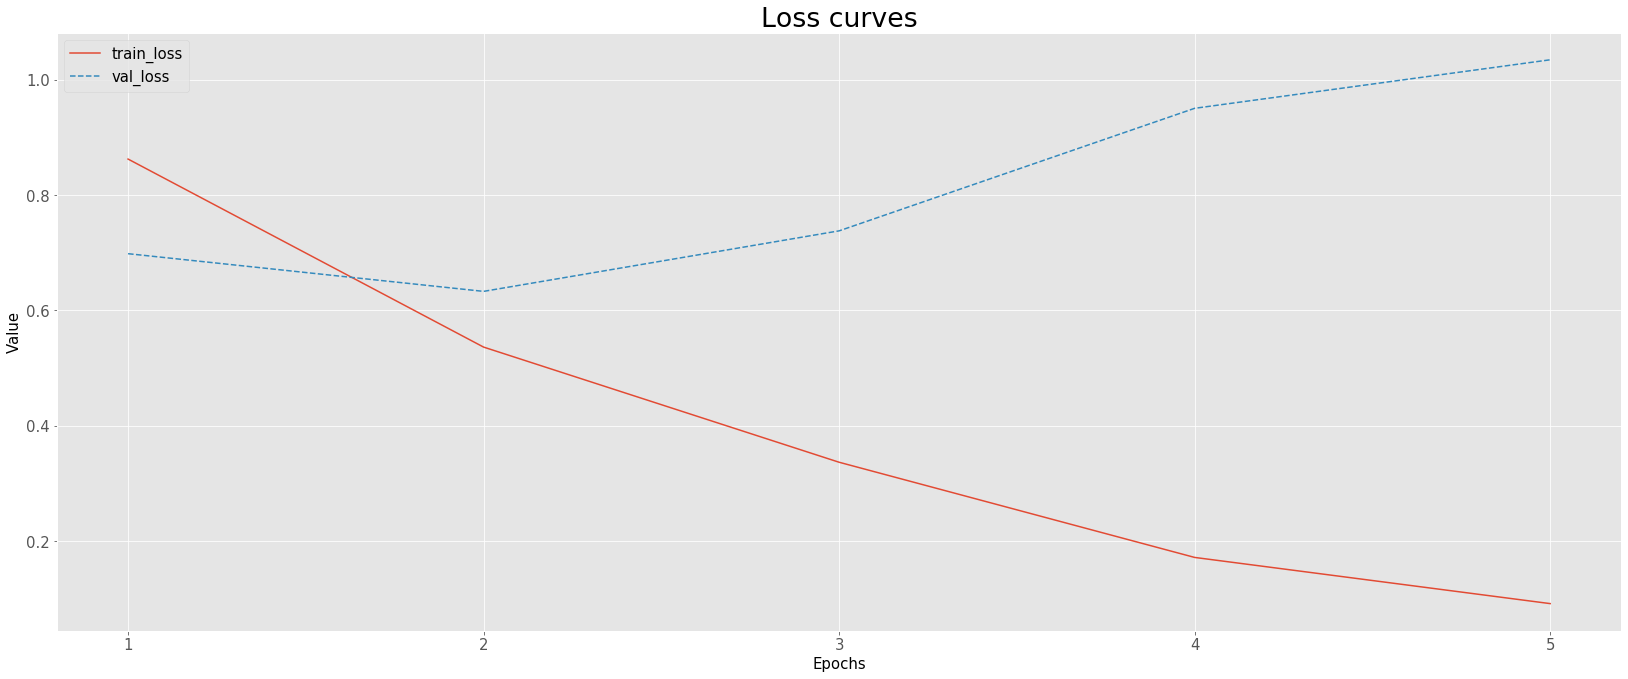

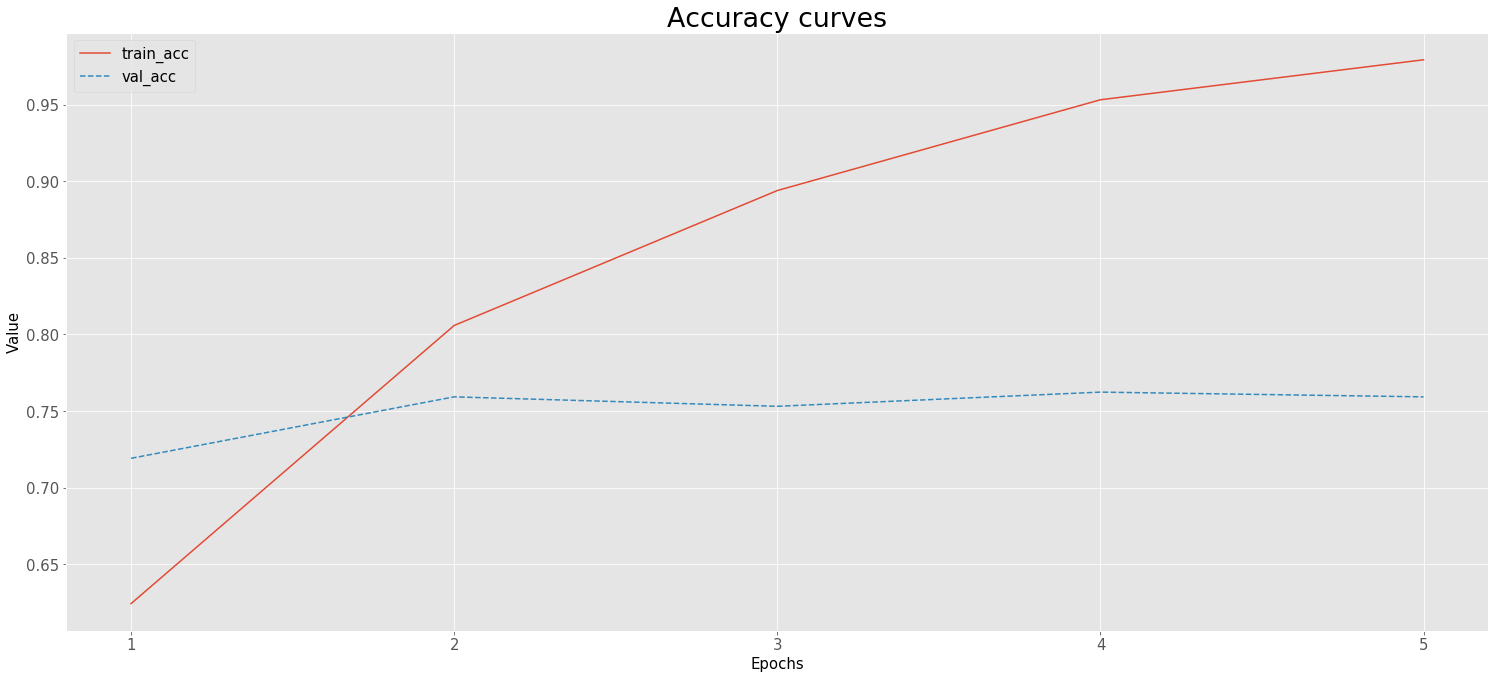

In [15]:
# Plot the loss curves
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_title='Loss curves', use_linestyles=['-', '--'], magnify=0.2)

# Plot the accuracy curves
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_title='Accuracy curves', use_linestyles=['-', '--'], magnify=0.2)

## Evaluation on the test dataset



  0%|          | 0/28 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.70      0.79      0.74       290
     neutral       0.76      0.70      0.73       290
    positive       0.78      0.76      0.77       290

    accuracy                           0.75       870
   macro avg       0.75      0.75      0.75       870
weighted avg       0.75      0.75      0.75       870

Normalized confusion matrix


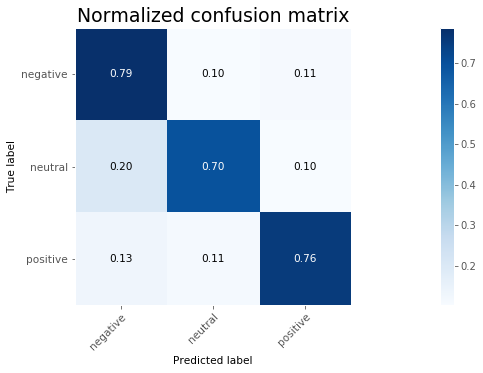

In [16]:
# Get model predictions on the test data
true_labels, predictions_labels, avg_epoch_loss = validation (test_dataloader, device)

# Create the evaluation report
evaluation_report = classification_report (true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))

# Print the evaluation report
print(evaluation_report)

# Plot confusion matrix
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1, 
                      use_title='Normalized confusion matrix'
                      );

## Save and load the entire PyTorch model

In [17]:
PATH = "/content/full_model.pt"
torch.save(model, PATH)

In [18]:
the_model = torch.load(PATH)

In [19]:
the_model.eval()

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La